MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
!pip install --upgrade tensorflow

In [1]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [3]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()




In [4]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [5]:
dcgan = DCGAN()
dcgan.train(epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.814718, acc.: 46.88%] [G loss: 1.257516]
1 [D loss: 0.398294, acc.: 81.25%] [G loss: 1.721273]
2 [D loss: 0.127578, acc.: 98.44%] [G loss: 2.760987]
3 [D loss: 0.060422, acc.: 100.00%] [G loss: 2.811426]
4 [D loss: 0.088692, acc.: 98.44%] [G loss: 3.347509]
5 [D loss: 0.060945, acc.: 100.00%] [G loss: 3.037765]
6 [D loss: 0.083109, acc.: 98.44%] [G loss: 2.990782]
7 [D loss: 0.065349, acc.: 100.00%] [G loss: 2.567843]
8 [D loss: 0.075783, acc.: 98.44%] [G loss: 2.906494]
9 [D loss: 0.121108, acc.: 95.31%] [G loss: 3.568609]
10 [D loss: 0.353354, acc.: 82.81%] [G loss: 4.725951]
11 [D loss: 0.661524, acc.: 70.31%] [G loss: 6.284513]
12 [D loss: 0.369043, acc.: 85.94%] [G loss: 6.939775]
13 [D loss: 0.404399, acc.: 79.69%] [G loss: 6.497667]
14 [D loss: 0.210133, acc.: 93.75%] [G loss: 5.432384]
15 [D loss: 0.130705, acc.: 98.44%] [G loss: 4.472334]
16 [D loss: 0.187138, acc.: 93.75%] [G loss: 3.060955]
17 [D loss: 0.084675, acc.: 100.00%] [G loss: 1.614282]
18 [D loss: 0.04

In [6]:
ls images

mnist_0.png     mnist_1650.png  mnist_2400.png  mnist_3100.png  mnist_3850.png
mnist_1000.png  mnist_1700.png  mnist_2450.png  mnist_3150.png  mnist_3900.png
mnist_100.png   mnist_1750.png  mnist_2500.png  mnist_3200.png  mnist_3950.png
mnist_1050.png  mnist_1800.png  mnist_250.png   mnist_3250.png  mnist_400.png
mnist_1100.png  mnist_1850.png  mnist_2550.png  mnist_3300.png  mnist_450.png
mnist_1150.png  mnist_1900.png  mnist_2600.png  mnist_3350.png  mnist_500.png
mnist_1200.png  mnist_1950.png  mnist_2650.png  mnist_3400.png  mnist_50.png
mnist_1250.png  mnist_2000.png  mnist_2700.png  mnist_3450.png  mnist_550.png
mnist_1300.png  mnist_200.png   mnist_2750.png  mnist_3500.png  mnist_600.png
mnist_1350.png  mnist_2050.png  mnist_2800.png  mnist_350.png   mnist_650.png
mnist_1400.png  mnist_2100.png  mnist_2850.png  mnist_3550.png  mnist_700.png
mnist_1450.png  mnist_2150.png  mnist_2900.png  mnist_3600.png  mnist_750.png
mnist_1500.png  mnist_2200.png  mnist_2950.png  mnist_3650.png

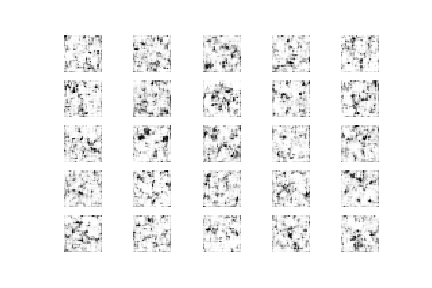

In [7]:
from IPython.display import display
from PIL import Image


path="images/mnist_0.png"
display(Image.open(path))

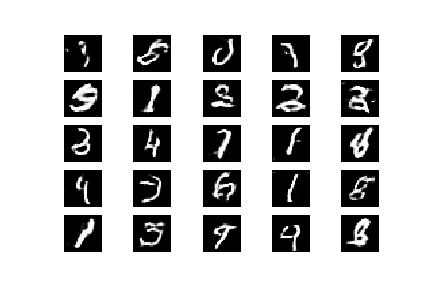

In [8]:

from IPython.display import display
from PIL import Image


path="images/mnist_3950.png"
display(Image.open(path))